In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [4]:
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [6]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1] # indexes less than the last values of train
test_idx = df.index > train.index[-1] # indexes greater than the last value of train

In [7]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

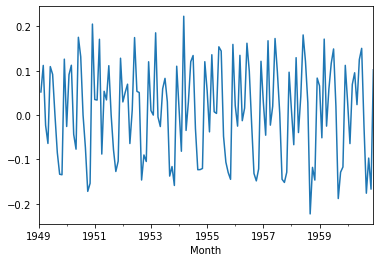

In [42]:
df['DiffLogPassengers'].plot();

In [43]:
df.shape

(144, 10)

In [8]:
# make supervised dataset

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10 # number of lags
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [9]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [10]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

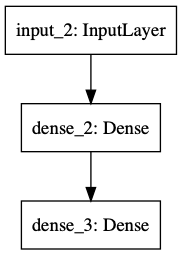

In [44]:
tf.keras.utils.plot_model(model)

In [11]:
model.compile(
    loss='mse',
    optimizer='adam',
    metrics='mae'
)

In [12]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0143 - mae: 0.1035 - val_loss: 0.0113 - val_mae: 0.0901
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0118 - mae: 0.0936 - val_loss: 0.0098 - val_mae: 0.0845
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0102 - mae: 0.0860 - val_loss: 0.0089 - val_mae: 0.0818
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0093 - mae: 0.0802 - val_loss: 0.0085 - val_mae: 0.0792
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0088 - mae: 0.0769 - val_loss: 0.0082 - val_mae: 0.0767
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0083 - mae: 0.0740 - val_loss: 0.0078 - val_mae: 0.0742
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0077 - mae: 0.0711 - val_loss: 0.0075 - val_mae: 0.0716
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0072 - mae: 0.0685 - va

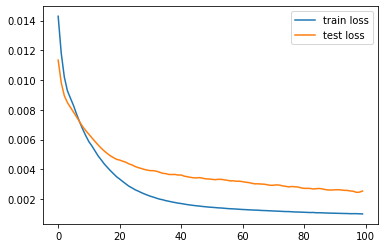

In [13]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [14]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [15]:
Ptrain = model.predict(Xtrain).flatten() # turn to 1D array
Ptest = model.predict(Xtest).flatten()

In [16]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

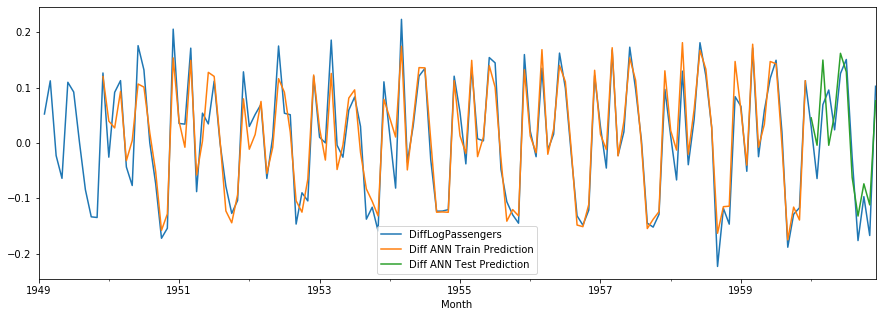

In [17]:
cols = ['DiffLogPassengers',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15,5));

In [19]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [20]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [21]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

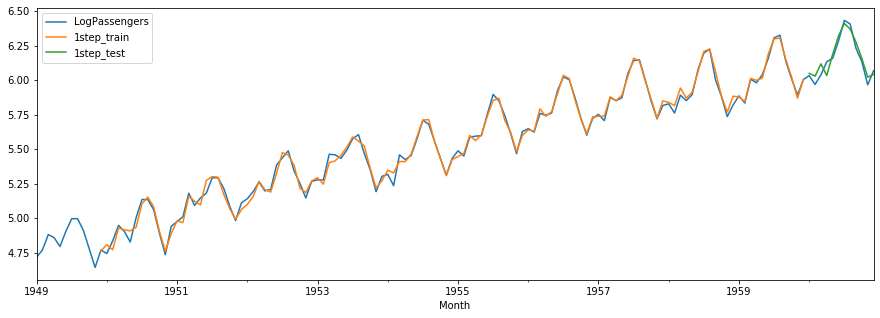

In [22]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15,5));

In [23]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1,-1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [24]:
# save multistep forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

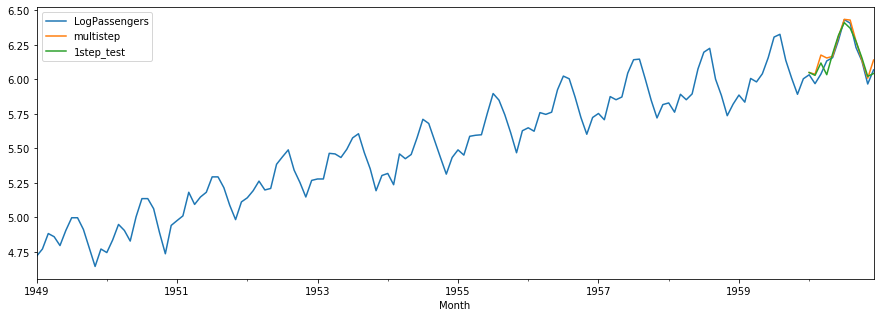

In [25]:
cols = ['LogPassengers', 'multistep', '1step_test']
df[cols].plot(figsize=(15,5));

In [26]:
# make multi-output supervised dataset
Tx = T # number of step in the input
Ty = Ntest # number of steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [27]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [28]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i,x)

In [29]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [31]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=100,
    validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0144 - val_loss: 0.0104
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0103
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0103
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 11/100
4/4 [==========

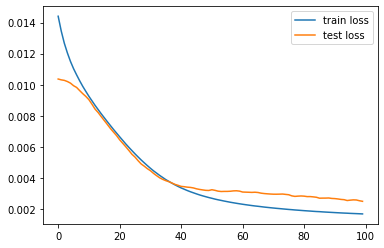

In [32]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [33]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [34]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [35]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [36]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

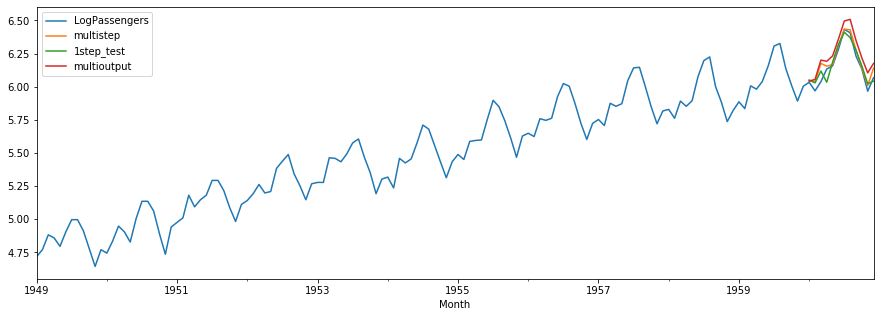

In [37]:
# plot all forecasts
cols = ['LogPassengers','multistep','1step_test','multioutput']
df[cols].plot(figsize=(15,5));

In [38]:
# MAPE
test_log_loss = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.006435877290717158
multi-output MAPE: 0.014659514610411782
